Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

The program was tested for 0.3.1.0 version of Dolfinx.

In [53]:
import meshio
import numpy as np

import ufl
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc
import time

import sys
sys.path.append("../..")
import fenicsx_support as fs
sys.path.append("../../optimisation")
import plasticity_framework as pf

In [54]:
if MPI.COMM_WORLD.rank == 0:

    #It works with the msh4 only!!
    msh = meshio.read("thick_cylinder.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)
    


<meshio mesh object>
  Number of points: 811
  Number of cells:
    line: 10
    line: 69
    line: 10
    line: 53
    triangle: 1478
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [55]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [56]:
# elastic parameters

sig0_dim = 70e3 #[Pa]
Ri_dim = 1.0 #[m]

E = 70e3 / sig0_dim
nu = 0.3
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu) #fem.Constant(mesh, PETSc.ScalarType(E/2./(1+nu)))
sig0 = 250 / sig0_dim #fem.Constant(mesh, PETSc.ScalarType(250 / sig0_dim))  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

In [57]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')

W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)

In [58]:
sig = fem.Function(W)
p = fem.Function(W0)
dp = fem.Function(W0)
u = fem.Function(V, name="Total_displacement")
Du = fem.Function(V, name="Current_increment")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

In [59]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [60]:
n = ufl.FacetNormal(mesh)
q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0)

loading = fem.Constant(mesh, PETSc.ScalarType(0.0 * q_lim))

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def sigma(eps_el):
    return lmbda*ufl.tr(eps_el)*ufl.Identity(3) + 2*mu*eps_el

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0],
                          [X[3], X[1], 0],
                          [0, 0, X[2]]])

ppos = lambda x: (x + ufl.sqrt(x**2))/2.

def proj_sig(Du, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(eps(Du))
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    # dp = ufl.conditional(f_elas > 0, f_elas/(3*mu+H), 0)
    dp = ppos(f_elas)/(3*mu+H)
    beta = ufl.conditional(f_elas > 0, 3*mu*dp/sig_eq, 0)
    new_sig = sig_elas-beta*s
    return ufl.as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]), \
           dp

def deps_p(deps, old_sig, old_p):
    sig_n = as_3D_tensor(old_sig)
    sig_elas = sig_n + sigma(deps)
    s = ufl.dev(sig_elas)
    sig_eq = ufl.sqrt(3/2.*ufl.inner(s, s))
    f_elas = sig_eq - sig0 - H*old_p
    dp_sig_eq = ufl.conditional(f_elas > 0, f_elas/(3*mu+H)/sig_eq, 0) # sig_eq is equal to 0 on the first iteration
    # dp = ppos(f_elas)/(3*mu+H) # this approach doesn't work with ufl.derivate
    return 3./2. * dp_sig_eq * s 

In [61]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

In [62]:
petsc_options_SNES = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-09,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    # "snes_monitor": "",
    "snes_monitor_cancel": "",
}

petsc_options_SNESQN = {
    "snes_type": "qn",
    "snes_qn_type": "lbfgs", #lbfgs broyden, badbroyden
    "snes_qn_m": 100,
    "snes_qn_scale_type": "jacobian", #<diagonal,none,scalar,jacobian> 	
    "snes_qn_restart_type": "none", #<powell,periodic,none> 
    "pc_type": "cholesky", # cholesky >> hypre > gamg,sor ; asm, lu, gas - don't work
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 0.0,
    "snes_max_it": 500,
    # "snes_monitor": "",
    "snes_monitor_cancel": "",
}

residual = ufl.inner(as_3D_tensor(sig) + sigma(eps(Du) - deps_p(eps(Du), sig, p)), eps(u_))*dx - F_ext(u_)
J = ufl.derivative(ufl.inner(sigma(eps(Du) - deps_p(eps(Du), sig, p)), eps(u_))*dx, Du, v)
J = ufl.derivative(ufl.inner(sigma(eps(Du)), eps(u_))*dx, Du, v)

my_problem = pf.SNESProblem(residual, Du, J, bcs, petsc_options=petsc_options_SNES, inside_Newton=None)

In [63]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u
x_point = np.array([[Ri, 0, 0]])
cells, points_on_proc = fs.find_cell_by_point(mesh, x_point)

In [64]:
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))
load_steps = load_steps
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "plasticity.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
# xdmf.write_mesh(mesh)

sig.vector.set(0.0)
p.vector.set(0.0)
u.vector.set(0.0)

return_mapping_times = np.zeros((len(load_steps)))

start = time.time()

for (i, t) in enumerate(load_steps):
    return_mapping_times_tmp = []
    loading.value = t * q_lim

    Du.x.array[:] = 0

    nits = my_problem.solve()
    print(f'nits = {nits}')

    nRes0 = my_problem.b.norm() # Which one? - ufl.sqrt(Res.dot(Res))
    nRes = nRes0

    if MPI.COMM_WORLD.rank == 0:
        print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {t * q_lim}")
   
    sig_, dp_ = proj_sig(Du, sig, p)
    fs.interpolate_quadrature(sig_, sig)
    fs.interpolate_quadrature(dp_, dp)
    p.vector.axpy(1, dp.vector)
    p.x.scatter_forward()
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    # fs.project(p, p_avg)
    
    # xdmf.write_function(u, t)
    # xdmf.write_function(p_avg, t)

    if len(points_on_proc) > 0:
        results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

# xdmf.close()
# end = time.time()

  0 SNES Function norm 4.076689120572e-05 
  1 SNES Function norm 4.196152685008e-17 
nits = 1

nRes0 , 4.196152685007988e-17 
 Increment: 1, load = 0.0002537449238735671
  0 SNES Function norm 1.688619923319e-05 
  1 SNES Function norm 1.737642291889e-17 
nits = 1

nRes0 , 1.737642291889002e-17 
 Increment: 2, load = 0.00035884951272532715
  0 SNES Function norm 1.295723639602e-05 
  1 SNES Function norm 1.355870561097e-17 
nits = 1

nRes0 , 1.3558705610973793e-17 
 Increment: 3, load = 0.0004394991003117152
  0 SNES Function norm 1.092345557650e-05 
  1 SNES Function norm 1.122479344653e-17 
nits = 1

nRes0 , 1.1224793446532689e-17 
 Increment: 4, load = 0.0005074898477471342
  0 SNES Function norm 9.623757555887e-06 
  1 SNES Function norm 9.826898729206e-18 
nits = 1

nRes0 , 9.82689872920596e-18 
 Increment: 5, load = 0.0005673908987268053
  0 SNES Function norm 8.700541886239e-06 
  1 SNES Function norm 9.021729598350e-18 
nits = 1

nRes0 , 9.021729598350359e-18 
 Increment: 6, l

KeyboardInterrupt: 

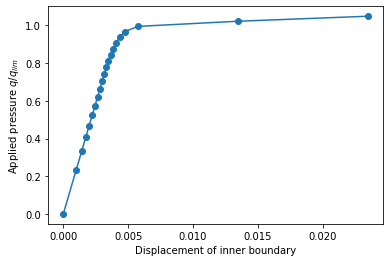

In [ ]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()